# Motif embeddings
## Theory:
Parse through the corpus of Bach chorales and record every 'motif', i.e. every way in which a part uses up one beat.
Things to watch out for:
- Ties belong to the note they start on.
- Fermata
- Tuplets (none in chorales, so no need to worry here.)
- Beams
- Metres with other than a crotchet base (only one in the dataset, so simply remove it for now).

## Notation:
A motif can be rendered as such: (length of first note, interval to second note, length of second note, interval to third note etc.)


## Rough notes
- Introduce a new notation: for a single voice [

# A library for applying machine learning to written music
# To be called Dunstaple
## Requirements
- A class that represents pieces as multidimensional arrays of numbers.
      - The class should be simple, focusing on the 'inherent' note rather than how it is displayed.
      - Details such as dynamics, expressions and words should be ignored
      - There should be easy ways to perform simple transformations such as transposition and rhythmic augmentation. 
- A way to create an instance of that class from an mei or mxl file.
- A way to write an instance of that class back to an mei file for displaying and sharing.
- A way to divide a piece up into different size units to create 'motif' embedding

In [80]:
import xml.etree.ElementTree as ET
import reference

def pitch_to_scientific(pitch):
    
    oct = (pitch + 8) // 12
    pname = reference.presumed_chr_scale[(pitch) % 12][0]
    accid = reference.presumed_chr_scale[(pitch) % 12][1]
    return {"pname":pname,"oct":oct,"accid":accid}

def enharmonic(sci_pitch,ks,mode="major"):
   
    guessed_tonic = reference.sigtokeymap[ks][0] if mode == "major" else reference.sigtokeymap[ks][1]
    out = dict(sci_pitch)
    note_tuple = (sci_pitch["pname"],sci_pitch["accid"])
    for eq_tuple in reference.enharm_equivs:
        if note_tuple in eq_tuple:
            if reference.leadingnotemap[guessed_tonic] in eq_tuple:
                out["pname"], out["accid"] = reference.leadingnotemap[guessed_tonic][0],reference.leadingnotemap[guessed_tonic][1]
                return out
    if ks in reference.all_keysigs["sharps"]:
        if sci_pitch["accid"] == "f":
            for eq_tuple in reference.enharm_equivs:
                if note_tuple in eq_tuple:
                    ind = eq_tuple.index(note_tuple) - 1
                    out["pname"], out["accid"] = eq_tuple[ind][0], eq_tuple[ind][1]
                    return out
        else:
            return out
    elif ks in reference.all_keysigs["flats"]:
        if sci_pitch["accid"] == "s":
            for eq_tuple in enharm_equivs:
                if note_tuple in eq_tuple:
                    ind = eq_tuple.index(note_tuple) + 1
                    out["pname"], out["accid"] = eq_tuple[ind][0], eq_tuple[ind][1]
                    return out
    return out

class Note:
    def __init__(self, pitch: int, length: int):
        self.pitch = pitch #0-88
        self.length = length #number of ratoms, or rhythmic atoms. e.g. if self.ratom=16, the rhythmic atom is a semiquaver, and the length of a crotchet is 16.

    def transpose(self, interval: int):
        self.pitch += interval

    def __str__(self):
        return f"{self.pitch}({self.length})"

    def copy(self):
        return Note(self.pitch, self.length)

class NotePlus(Note):
    def __init__(self, pitch: int, length: int, tie=False):
        super().__init__(pitch, length)
        self.tie = tie

    def copy(self):
        return NotePlus(self.pitch, self.length, self.tie)

    def __str__(self):
        return super().__str__() + self.tie * "t"


class Piece:
    def __init__(self, notes=None, nvoices=0, ratom=16, metadata={}):
        self.metadata = metadata # e.g {"composer":"JS Bach", "title":"Chorale from Meine Seel erhebt den Herren", "opus": "BWV 10.7"}
        self.notes = notes if notes is not None else [[[]] for _ in range(nvoices)]
        self.bars = [] # e.g if a ratom is a semiquaver and the first bar is a crotchet long: [{"length":4, "n":1},{"length":12, "n":15},{"length":8, "n":1}]
        self.keysigs = [] # e.g. [{"ks":2s, "nbars":16}] for a 16 bar piece in D major with no key changes
        self.timesigs = [] # e.g. [{"ts":[4,4],"nbars":16}]
        self.annotations = {} # e.g. {"fermata":[[48,120],[48,120],[48,120],[48,120]], "dynamics":[{"f":0, "p":4, "dim":[0,4]},{...},{...},{...}], with an object for each part referring to indices of ratoms to which they are assigned
        self.ratom = ratom # the rhythmic atom, i.e. the smallest rhythmic unit used. The numbers are as used in time signatures, i.e. 16 is a semiquaver.

    def getlength(self):
        total = 0
        for sec in self.notes[0]:
            for note in sec:
                total += note.length
        return total
        
    def transpose(self, interval: int):
        for voice in self.notes:
            for sec in voice:
                for note in sec:
                    note.transpose(interval)

    def __str__(self):
        out = []
        for i, voice in enumerate(self.notes):
            out.append([])
            for j, sec in enumerate(voice):
                out[i].append([])
                for k, note in enumerate(sec):
                    out[i][j].append(str(note))
        return str(out)


    def quantise(self, unitlength=4):
        notescopy = [[[note.copy() for note in section] for section in voice] for voice in self.notes]
        for i, voice in enumerate(notescopy):
            while len(voice) > 1:
                voice[0] += voice.pop(1)
            notescopy[i] = voice[0]
        quantised = []
        for i, voice in enumerate(notescopy):
            quantised.append([])
            unit, remainder = [], unitlength
            while len(voice) > 0:
                if voice[0].length == 0:
                    voice.pop(0)
                else:
                    length_to_add = min(remainder, voice[0].length)
                    tied = voice[0].tie if isinstance(voice[0],NotePlus) else voice[0].length > remainder
                    if len(unit) > 0 and unit[-1].tie:
                        unit[-1].length += length_to_add
                        unit[-1].tie = tied
                    else:
                        unit.append(NotePlus(voice[0].pitch,length_to_add,tied))
                    remainder -= length_to_add
                    voice[0].length -= length_to_add
                    if remainder == 0:
                        quantised[i].append(unit)
                        unit, remainder = [], unitlength
            if sum([n.length for n in quantised[i][-1]]) < remainder:
                unit.append(NotePlus(0,remainder))
                quantised[i].append(unit)
    
        return Piece(quantised)

    def addbars(self):
        quantised = self.quantise(1)
        counter = 0
        piecewithbars = [[] for voice in quantised.notes]
        for section in self.bars:
            workingnotes = Piece([[[unit[0].copy() for unit in voice[counter:counter+(section["length"]*section["n"])]]] for voice in quantised.notes])
            sectionwithbars = workingnotes.quantise(section["length"])
            for i, voice in enumerate(piecewithbars):
                voice.extend(sectionwithbars.notes[i])
        return Piece(piecewithbars)
    
    @staticmethod
    def from_mei(path,ratom=16):
        namespace = "{http://www.music-encoding.org/ns/mei}" #all tags will by default have the namespace attached at the front.
        tree = ET.parse(path)

        
        def reststonotes(tree):
            # changes rests to notes with pname and oct 'x'
            for rest in tree.iter(namespace + 'rest'):
                rest.tag = namespace + 'note'
                rest.set("pname","x")
                rest.set("oct","-1")
        
        def pitchtoint(note,oct,accid = "n"):
            # translates to the number counting up from A0
            if note == "x":
                return 0
            map = {"c":4, "d":6, "e":8, "f":9, "g":11, "a":13, "b":15}
            basepitch = (oct-1)*12 + map[note]
            if accid == "n":
                return basepitch
            if accid == "s":
                return basepitch + 1
            if accid == "f":
                return basepitch - 1
            if accid == "ss":
                return basepitch + 2
            if accid == "ff":
                return basepitch - 2
 
        def durtolen(dur,dots=0):
            length = ratom * 2 if dur == 0 else ratom // dur
            duplength = length
            for _ in range(dots):
                duplength = duplength // 2
                length += duplength
            return length
                
        def piecefromtree(tree):
            nvoices=0
            for _ in tree.iter(namespace + 'staffDef'):
                nvoices += 1
            piece = Piece(nvoices=nvoices)
            ties = [False for _ in range(nvoices)]
            for ts in tree.iter(namespace + 'meterSig'):# Hacky. To be changed at some point to deal with pieces with more than one time signature.
                barlength = int(ts.get('count')) * ratom // int(ts.get('unit'))
                break
            rpts = [] #to keep track of repeats in order to copy out repeated notes twice
            rptstart = 0
            for staffn in range(nvoices):
                for measure in tree.iter(namespace + 'measure'):
                    if staffn == 0 and measure.get('left') == "rptstart":
                        rptstart = len(piece.notes[staffn][0])
                    if staffn == 0 and measure.get('right') == "rptend":
                        rptendbarstart = len(piece.notes[staffn][0])
                        rpts.append([rptstart, rptendbarstart])
                    barrest = True
                    for staff in measure.iter(namespace + 'staff'):
                        if int(staff.get('n')) == staffn + 1:
                            for note in staff.iter(namespace + 'note'):
                                barrest = False
                                dots = int(note.get('dots')) if note.get('dots') else 0
                                if ties[staffn]:
                                    piece.notes[staffn][0][-1] += durtolen(int(note.get('dur')),dots)
                                    ties[staffn] = False
                                else:
                                    accid = note.get('accid.ges') if note.get('accid.ges') else "n"
                                    newpitch = pitchtoint(note.get('pname'), int(note.get('oct')), accid)
                                    newlength = durtolen(int(note.get('dur')),dots)
                                    piece.notes[staffn][0].append(Note(newpitch,newlength))
                                for tie in measure.iter(namespace + 'tie'):
                                    if tie.get('startid') == note.get('id'):
                                        ties[staffn] = True
                                        break
                    if barrest:
                        piece.notes[staffn][0].append(Note(0, barlength))
            # Duplicate notes in repeated sections
            for voice in piece.notes:
                for rpt_sec in rpts:
                    rpt_remainder = barlength
                    rpt_endindx = rpt_sec[1]
                    while rpt_remainder > 0: #will not work if there is a tie over the repeat: to be sorted out later
                        rpt_remainder -= voice[0][rpt_endindx].length
                        rpt_endindx += 1
                    voice[0][rpt_endindx:rpt_endindx] = [note.copy() for note in voice[0][rpt_sec[0]:rpt_endindx]]
                
            return piece
        reststonotes(tree)
        return piecefromtree(tree)


# To do:
- Test
- Function that adds accid.ges to every 'black note' if it doesn't exist
- Alternate representations
    - Interval
    - Unit time
- Method that puts out a mei tree from a Piece
- Find most common units
- Add method that assigns self.bars from units

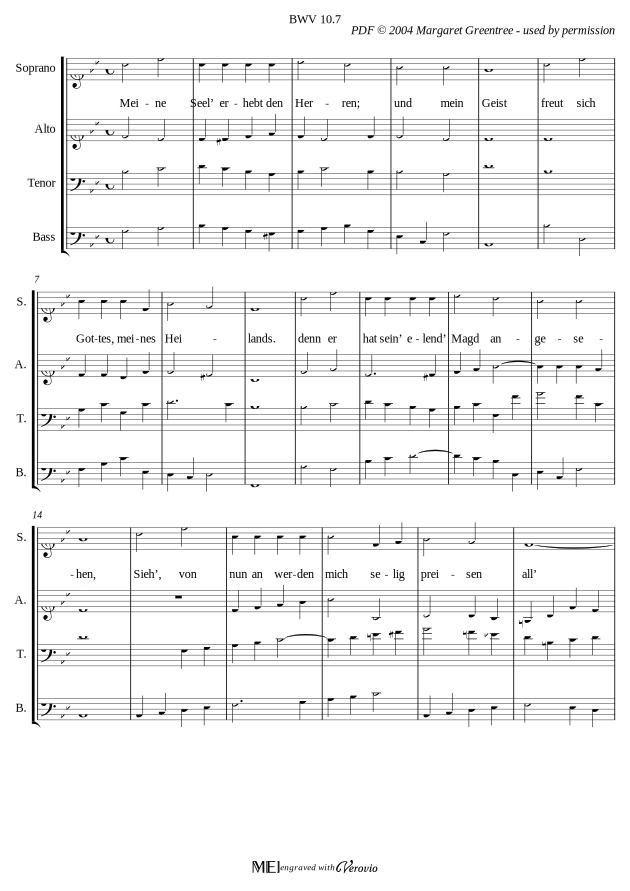

In [85]:
from verovio import toolkit
from IPython import display
testpiece0 = Piece.from_mei('corpus/bach/mei_versions/bwv10.7.mei')
tmptk = toolkit()
tmptk.loadFile('corpus/bach/mei_versions/bwv10.7.mei')
tmptk.setScale(30)
display.SVG(tmptk.renderToSVG())

In [79]:
print(testpiece0.addbars())

[[['66(8)', '69(8)'], ['66(4)', '66(4)', '66(4)', '66(4)'], ['67(8)', '66(8)'], ['64(8)', '64(8)'], ['62(16)'], ['66(8)', '69(8)'], ['64(4)', '64(4)', '64(4)', '59(4)'], ['62(8)', '61(8)'], ['59(16)'], ['66(8)', '69(8)'], ['66(4)', '66(4)', '66(4)', '66(4)'], ['67(8)', '66(8)'], ['64(8)', '64(8)'], ['62(16)'], ['66(8)', '69(8)'], ['64(4)', '64(4)', '64(4)', '64(4)'], ['64(8)', '59(4)', '61(4)'], ['62(8)', '61(8)'], ['59(16)'], ['59(16)'], ['59(16)'], ['59(16)']], [['59(8)', '57(8)'], ['57(4)', '57(4)', '59(4)', '61(4)'], ['59(4)', '57(8)', '59(4)'], ['59(8)', '57(8)'], ['57(16)'], ['57(16)'], ['57(4)', '57(4)', '55(4)', '59(4)'], ['59(8)', '57(8)'], ['54(16)'], ['59(8)', '61(8)'], ['57(12)', '57(4)'], ['59(4)', '61(4)', '62(8)'], ['62(4)', '62(4)', '62(4)', '61(4)'], ['57(16)'], ['0(16)'], ['57(4)', '59(4)', '61(4)', '62(4)'], ['64(8)', '52(8)'], ['54(8)', '54(4)', '52(4)'], ['51(4)', '54(4)', '59(4)', '57(4)'], ['55(16)'], ['55(8)', '54(4)', '52(4)'], ['54(16)']], [['50(8)', '52(8)'],